In [ ]:
#Importing all the necessary libraries required for this code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.recurrent import GRU
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
import h5py
from keras.models import load_model
import os
import tensorflow as tf
from datetime import datetime, timedelta

In [ ]:
#Code section to upload dataset to google drive for the execution
from google.colab import files
#uploaded = files.upload()#uncomment to upload a local file

In [ ]:
dataset = pd.read_excel("telstradataset.xlsx")#Read the excel dataset file 
dataset.head(180).tail(90)[['Date','Open']]#Display the top 10 rows
dataset.head(90)[['Date','Open']]#Display the top 10 rows

,Date,Open
0,2018-01-02,3.64
1,2018-01-03,3.67
2,2018-01-04,3.68
3,2018-01-05,3.70
4,2018-01-08,3.74
...,...,...
85,2018-05-07,3.26
86,2018-05-08,3.26
87,2018-05-09,3.24
88,2018-05-10,3.22


In [ ]:
training_set = dataset
training_set.describe()#Display the statistics of the dataset

,Open,High,Low,Close,Adj Close,Volume,AverageSentiment_tweets,Two_day_sentiment_tweets,Three_day_sentiment_tweets,AverageSentimentNews,Two_day_sentiment_news
count,761.000000,761.000000,761.000000,761.000000,761.000000,7.610000e+02,761.000000,761.000000,761.000000,761.000000,761.000000
mean,3.270539,3.301380,3.240736,3.272017,3.159929,2.907550e+07,0.105556,0.094729,0.097954,0.044543,0.037431
std,0.337309,0.338043,0.335868,0.337741,0.330581,1.488642e+07,0.248223,0.144423,0.111183,0.142651,0.111218
min,2.620000,2.640000,2.600000,2.620000,2.476862,3.164766e+06,-0.790670,-0.342730,-0.263230,-0.675950,-0.675950
25%,3.030000,3.070000,3.010000,3.040000,2.930638,1.956644e+07,-0.042410,0.002523,0.030430,0.000000,-0.009276
50%,3.220000,3.250000,3.180000,3.210000,3.099957,2.592040e+07,0.115999,0.087713,0.091217,0.000000,0.013158
75%,3.560000,3.580000,3.520000,3.560000,3.433497,3.449690e+07,0.253755,0.181862,0.171017,0.102800,0.090959
max,3.980000,4.010000,3.950000,3.990000,3.850433,1.273549e+08,0.843987,0.631044,0.588664,0.776325,0.781137


In [ ]:
training_set.isnull().sum()#Check if any element has NULL value
#In the dataset as there is no NULL value and so no pro-processing is necessary

Date                          0
Open                          0
High                          0
Low                           0
Close                         0
Adj Close                     0
Volume                        0
AverageSentiment_tweets       0
Two_day_sentiment_tweets      0
Three_day_sentiment_tweets    0
AverageSentimentNews          0
Two_day_sentiment_news        0
dtype: int64

In [ ]:
training_set = dataset[dataset['Date']<'2020-11-01'].copy()#Separate the dataset based on date
testing_set = dataset[dataset['Date']>='2020-11-01'].copy()#Testing dataset
print(training_set.shape)
print(testing_set.shape)

model_trained_date = datetime.strptime('2020-11-10', "%Y-%m-%d")
prediction_date = datetime.strptime('2020-11-10', "%Y-%m-%d")

###These are the dates/dataframes we need to fit the model for
to_be_fitted_data = training_set[training_set['Date']>='2020-11-10'].copy()
print(len(to_be_fitted_data))

days_to_train = len(to_be_fitted_data)

(719, 12)
(42, 12)
0


Both the training and testing dataset consists of 12 columns, the rows varies. But all the columns will not be used for analysis and so the columns to be used must be selected.

In [ ]:
################
'''This section was created for report X_train and y_train explanation purposes'''
################
'''X_train1 = []
y_train1 = []

training_set1 = training_set[['Open']]
sc = MinMaxScaler()#setting the range between 0 and 1
training_set1 = sc.fit_transform(training_set1)

for i in range(90,training_set1.shape[0]-3):
  X_train1.append(training_set1[i-90:i])#if only a single column is used then only append the first column
  y_train1.append(training_set1[i:i+2, 0])
print("X_train")
sc.inverse_transform(X_train)
print("y_train")
print(sc.inverse_transform(np.array(y_train1)))'''

'X_train1 = []\ny_train1 = []\n\ntraining_set1 = training_set[[\'Open\']]\nsc = MinMaxScaler()#setting the range between 0 and 1\ntraining_set1 = sc.fit_transform(training_set1)\n\nfor i in range(90,training_set1.shape[0]-3):\n  X_train1.append(training_set1[i-90:i])#if only a single column is used then only append the first column\n  y_train1.append(training_set1[i:i+2, 0])\nprint("X_train")\nsc.inverse_transform(X_train)\nprint("y_train")\nprint(sc.inverse_transform(np.array(y_train1)))'

In [ ]:
training_set.columns### The names of all the columns present in the dataset

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'AverageSentiment_tweets', 'Two_day_sentiment_tweets',
       'Three_day_sentiment_tweets', 'AverageSentimentNews',
       'Two_day_sentiment_news'],
      dtype='object')

In [ ]:
#Need to select the columns on which analysis is to be made
#training_set = training_set[['Open','High','Low','Close','Volume','AverageSentiment_tweets','AverageSentimentNews']]
selected_columns = ['Open','High','Low','Close','Two_day_sentiment_tweets','AverageSentimentNews']#Mention the columns to be selected for the analysis purpose
training_set = training_set[selected_columns]
print(training_set.columns)
print(training_set.tail(10))

Index(['Open', 'High', 'Low', 'Close', 'Two_day_sentiment_tweets',
       'AverageSentimentNews'],
      dtype='object')
     Open   High    Low  Close  Two_day_sentiment_tweets  AverageSentimentNews
709  2.85  2.860  2.840   2.85                 -0.228680              0.073783
710  2.84  2.850  2.790   2.80                  0.165392              0.052954
711  2.80  2.815  2.785   2.79                  0.174280              0.070355
712  2.78  2.790  2.750   2.75                  0.307436              0.063633
713  2.76  2.770  2.720   2.73                  0.257806              0.449475
714  2.74  2.770  2.730   2.76                  0.157281              0.158021
715  2.74  2.745  2.700   2.71                  0.007545             -0.006100
716  2.71  2.720  2.700   2.70                 -0.125270             -0.010750
717  2.70  2.715  2.660   2.69                  0.019245              0.393121
718  2.70  2.710  2.670   2.68                  0.019245              0.000000


In [ ]:
#Just testing out min max sxale values 
#training_set.sort_values(by=['Open'])
#training_set[training_set['Date']=='2020-11-30'] = 9.0
#training_set.sort_values(by=['Open'])

In [ ]:
#Code section to scale the training set 
sc = MinMaxScaler()#setting the range between 0 and 1
training_set_scaled = sc.fit_transform(training_set)#Transform the training set into scaled features
print("Scalar Minimum value:" + str(sc.min_))
print("Scalar scale value:" + str(sc.scale_))

Scalar Minimum value:[-1.92647059 -1.9270073  -1.92592593 -1.91240876  0.35196052  0.46544215]
Scalar scale value:[0.73529412 0.72992701 0.74074074 0.72992701 1.02693233 0.68857482]


In [ ]:
# Creating a data structure with 90 timesteps and 1 output
#because rnn must have historical data and so training set will have 90 previous days data in different columns
#and the actual stock value in the y_train value
X_train = []
y_train = []

###Setting the future days for which it needs to be predicted
future_days = 1
for i in range(90,training_set_scaled.shape[0]-future_days+1):
  if training_set_scaled.shape[1]==1:
    X_train.append(training_set_scaled[i-90:i, 0])#if only a single column is used then only append the first column
  else:
    X_train.append(training_set_scaled[i-90:i])#if multiple columns are used then append all columns
  y_train.append(training_set_scaled[i:i+future_days, 0])

X_train, y_train = np.array(X_train), np.array(y_train)##Convert it into an array
print("The training set is of shape:" + str(X_train.shape))
print("The testing set if of shape:" + str(y_train.shape))

The training set is of shape:(629, 90, 6)
The testing set if of shape:(629, 1)


In [ ]:
scale1 = MinMaxScaler()
scale1.min_,scale1.scale_ = sc.min_[0],sc.scale_[0]##Taking the scalar values from the previous scalar
##Because the previous scalar had n dimensions but now the predicted is only 1 column

print("Checking if the RNN data was setup properly")
##The predicted price and the test data is inverse transformed
#print(scale1.inverse_transform(X_train[:,:,0]))
#print(scale1.inverse_transform(y_train))

Checking if the RNN data was setup properly


In [ ]:
# The xtrain dataset needs to be reshaped if it consist of only one column data
if training_set_scaled.shape[1]==1:
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))#uncomment if only one column is used

In [ ]:
train_model = 'LSTM'
if train_model=='LSTM':
  if os.path.isfile("LSTM_trained_model.h5"):
    regressior = load_model('LSTM_trained_model.h5')
  else:  
    #Building the Recurrent Neural Network LSTM
    regressior = Sequential() #initializing the RNN by saying that the model will be sequential
    # Adding the first LSTM layer and some Dropout regularisation
    regressior.add(LSTM(units = 320, activation = 'tanh', return_sequences = True, input_shape = (X_train.shape[1], training_set_scaled.shape[1])))
    regressior.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    #regressior.add(LSTM(units = 60, activation = 'tanh', return_sequences = True))
    ##regressior.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    #regressior.add(LSTM(units = 160, activation = 'tanh', return_sequences = True))
    #regressior.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    regressior.add(LSTM(units = 240, activation = 'tanh'))
    regressior.add(Dropout(0.2))
    # Adding the output layer
    regressior.add(Dense(units = future_days))
    print(regressior.summary())
    plot_model(regressior, to_file='LSTM_model_plot.png', show_shapes=True, show_layer_names=True)
    # Compiling the RNN
    regressior.compile(optimizer = 'adam', loss = 'mean_squared_error',)

    # Fitting the RNN to the Training set
    regressior.fit(X_train, y_train, epochs = 50, batch_size = 16,validation_split=0.1,verbose=1)
    regressior.save("LSTM_trained_model.h5")
    print("model_saved")
elif train_model=='GRU':
  if os.path.isfile("GRU_trained_model.h5"):
    regressior = load_model('GRU_trained_model.h5')
  else: 
    #Building the Recurrent Neural Network GRU
    regressior = Sequential() #initializing the RNN by saying that the model will be sequential
    regressior.add(GRU(units=320,activation = 'tanh',return_sequences=True,input_shape = (X_train.shape[1], training_set_scaled.shape[1])))
    regressior.add(Dropout(0.2))
    ##Adding a seconf layer
    #regressior.add(GRU(units=80,activation = 'tanh',return_sequences=True))
    #regressior.add(Dropout(0.2))
    #regressior.add(GRU(units=60,activation = 'tanh',return_sequences=True))
    #regressior.add(Dropout(0.2))
    regressior.add(GRU(units=240,activation = 'tanh'))
    regressior.add(Dropout(0.2))
    ##Adding the final dense layer
    regressior.add(Dense(future_days))
    print(regressior.summary())
    plot_model(regressior, to_file='GRU_model_plot.png', show_shapes=True, show_layer_names=True)
    regressior.compile(loss='mse', optimizer='adam')
    regressior.fit(X_train,y_train,batch_size=16, epochs=50, validation_split=0.1, verbose=1)
    regressior.save("GRU_trained_model.h5")
    print("model_saved")

In [ ]:
for layer in regressior.layers:
  print(layer)
  weights = layer.get_weights() # list of numpy arrays
  for w in weights:
    print(w.shape)
  #print(weights)
  print(".........................")

(6, 1280)
(320, 1280)
(1280,)
.........................
.........................
(320, 960)
(240, 960)
(960,)
.........................
.........................
(240, 1)
(1,)
.........................


In [ ]:
past_90_days = training_set.tail(90)##As the testing set must have access to the past 90 days of data and so the last 90 daya data is fetched from the training set
testing_set = past_90_days.append(testing_set, ignore_index = True)
testing_set = testing_set[selected_columns]
print(testing_set.columns)

testing_set = sc.transform(testing_set)##The testing set is also scaled using the minmax scaler

X_test = []
y_test = []

for i in range(90, testing_set.shape[0]-future_days+1):
  if training_set_scaled.shape[1]==1:
    X_test.append(testing_set[i-90:i, 0])
  else:
    X_test.append(testing_set[i-90:i])
  y_test.append(testing_set[i:i+future_days, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
print("The shape of testing data input is "+str(X_test.shape))
print("The shape of testing data output is " + str(y_test.shape))


Index(['Open', 'High', 'Low', 'Close', 'Two_day_sentiment_tweets',
       'AverageSentimentNews'],
      dtype='object')
The shape of testing data input is (42, 90, 6)
The shape of testing data output is (42, 1)


In [ ]:
print(X_test[0].shape)
x_test = X_test[0]

(90, 6)


In [ ]:
no_of_samples = len(X_test)
print(no_of_samples)
batch_size=1
nb_epoch=1

42


In [ ]:
from keras.callbacks import Callback

class LossHistory(Callback):
  def on_train_begins(self,logs={}):
    self.losses = []
  
  def on_batch_end(self,batch,logs={}):
    self.losses.append(logs.get('loss'))

In [ ]:
online_history = LossHistory()
online_history

In [ ]:
'''#### This section of code is to fit the trained model on the to be fitted data
x_train_new = X_train.copy()
y_train_new = y_train.copy()
x_test_new = X_test.copy()
y_test_new = y_test.copy()
print(regressior.evaluate(x_train_new,y_train_new,verbose=0))
print(regressior.evaluate(x_test_new,y_test_new,verbose=0))
print(x_train_new[-3:,].shape)


opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
regressior.compile(optimizer = opt, loss = 'mean_squared_error',)
indexed = 0-days_to_train
while indexed!=-1:
  print(x_train_new[indexed:indexed+1,])
  regressior.fit(x_train_new[indexed:indexed+1,],y_train_new[indexed:indexed+1,],1,2,verbose=0)
  indexed = indexed+1

print(regressior.evaluate(x_train_new,y_train_new,verbose=0))
print(regressior.evaluate(x_test_new,y_test_new,verbose=0))
'''

"#### This section of code is to fit the trained model on the to be fitted data\nx_train_new = X_train.copy()\ny_train_new = y_train.copy()\nx_test_new = X_test.copy()\ny_test_new = y_test.copy()\nprint(regressior.evaluate(x_train_new,y_train_new,verbose=0))\nprint(regressior.evaluate(x_test_new,y_test_new,verbose=0))\nprint(x_train_new[-3:,].shape)\n\n\nopt = tf.keras.optimizers.Adam(learning_rate=0.00005)\nregressior.compile(optimizer = opt, loss = 'mean_squared_error',)\nindexed = 0-days_to_train\nwhile indexed!=-1:\n  print(x_train_new[indexed:indexed+1,])\n  regressior.fit(x_train_new[indexed:indexed+1,],y_train_new[indexed:indexed+1,],1,2,verbose=0)\n  indexed = indexed+1\n\nprint(regressior.evaluate(x_train_new,y_train_new,verbose=0))\nprint(regressior.evaluate(x_test_new,y_test_new,verbose=0))\n"

In [ ]:
Iteration_checkpoint = 1000
train_score_list = []
test_score_list = []
before_train_predict_rmse_score = []
train_predict_rmse_score = []
test_predict_rmse_score = []
before_test_predict_rmse_score = []
x_train_new = X_train.copy()
y_train_new = y_train.copy()
x_test_new = X_test.copy()
y_test_new = y_test.copy()
print(len(x_train_new))
print(len(x_test_new))

no_of_samples = len(y_test_new)
previous_samples = len(y_train_new)

#model is trained till 15 dec 2020
#if giving dates of 17 dec 2020

days_to_train=20
for i in range(days_to_train):
  ##First the new data must be created
  #print(y_test_new)
  #training on the ith data point

  nb_epoch=4
  print(i)
  print(regressior.evaluate(x_train_new,y_train_new,verbose=0))
  print(regressior.evaluate(x_test_new,y_test_new,verbose=0))
  ###Predict training data
  predicted_stock_price_on_trainingset1 = regressior.predict(x_train_new)
  scale = MinMaxScaler()
  scale.min_,scale.scale_ = sc.min_[0],sc.scale_[0]##Taking the scalar values from the previous scalar
  predicted_stock_price_on_trainingset2 = scale.inverse_transform(predicted_stock_price_on_trainingset1)
  y_train2 = scale.inverse_transform(y_train_new)#.reshape(-1,1))

  before_train_predict_rmse_score.append(mean_squared_error(y_train2, predicted_stock_price_on_trainingset2))
  ###Predict testing data
  if training_set_scaled.shape[1]==1:
    x_test_new = np.reshape(x_test_new, (x_test_new.shape[0], x_test_new.shape[1], 1))#uncomment if only one column is used
  predicted_stock_price1 = regressior.predict(x_test_new)
  scale = MinMaxScaler()
  scale.min_,scale.scale_ = sc.min_[0],sc.scale_[0]##Taking the scalar values from the previous scalar
  predicted_stock_price1 = scale.inverse_transform(predicted_stock_price1)
  y_test2 = scale.inverse_transform(y_test_new)#.reshape(-1,1))
  before_test_predict_rmse_score.append(mean_squared_error(y_test2, predicted_stock_price1))
  print("...............")
  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
  regressior.compile(optimizer = opt, loss = 'mean_squared_error',)
  regressior.fit(x_test_new[0:1],y_test_new[0:1],batch_size,nb_epoch,verbose=0)

  train_score = regressior.evaluate(x_train_new,y_train_new,verbose=0)
  test_score = regressior.evaluate(x_test_new,y_test_new,verbose=0)
  print(train_score)
  print(test_score)
  print("################")

  ###Predict training data
  predicted_stock_price_on_trainingset = regressior.predict(x_train_new)
  scale = MinMaxScaler()
  scale.min_,scale.scale_ = sc.min_[0],sc.scale_[0]##Taking the scalar values from the previous scalar
  predicted_stock_price_on_trainingset1 = scale.inverse_transform(predicted_stock_price_on_trainingset)
  y_train1 = scale.inverse_transform(y_train_new)#.reshape(-1,1))

  train_predict_rmse_score.append(mean_squared_error(y_train1, predicted_stock_price_on_trainingset1))

  ###Predict testing data
  if training_set_scaled.shape[1]==1:
    x_test_new = np.reshape(x_test_new, (x_test_new.shape[0], x_test_new.shape[1], 1))#uncomment if only one column is used
  predicted_stock_price = regressior.predict(x_test_new)
  scale = MinMaxScaler()
  scale.min_,scale.scale_ = sc.min_[0],sc.scale_[0]##Taking the scalar values from the previous scalar
  predicted_stock_price = scale.inverse_transform(predicted_stock_price)
  y_test1 = scale.inverse_transform(y_test_new)#.reshape(-1,1))
  test_predict_rmse_score.append(mean_squared_error(y_test1, predicted_stock_price))

  ###Remove the fitted data from testing to training data set
  train_score_list.append(train_score)
  test_score_list.append(test_score)

  x_train_new_list = []
  for j in range(len(x_train_new)):
    x_train_new_list.append(x_train_new[j])

  y_train_new_list = []
  for j in range(len(y_train_new)):
    y_train_new_list.append(y_train_new[j])

  x_test_new_list = []
  for j in range(len(x_test_new)):
    x_test_new_list.append(x_test_new[j])

  y_test_new_list = []
  for j in range(len(y_test_new)):
    y_test_new_list.append(y_test_new[j])

  x_train_new_list.append(x_test_new[0])
  y_train_new_list.append(y_test_new[0])
  del x_test_new_list[0]
  del y_test_new_list[0]
  
  x_train_new=np.array(x_train_new_list)
  y_train_new=np.array(y_train_new_list)
  x_test_new=np.array(x_test_new_list)
  y_test_new=np.array(y_test_new_list)
  print(x_train_new.shape)
  print(y_train_new.shape)
  print(x_test_new.shape)
  print(y_test_new.shape)
  
train_score_list

629
42
0
0.0007905485108494759
0.0007255225791595876
...............
0.0006339044193737209
0.0007099791546352208
################
(630, 90, 6)
(630, 1)
(41, 90, 6)
(41, 1)
1
0.0006336391088552773
0.0007159122615121305
...............
0.0007799433078616858
0.0007872933056205511
################
(631, 90, 6)
(631, 1)
(40, 90, 6)
(40, 1)
2
0.0007790521485731006
0.0008015349740162492
...............
0.0010527214035391808
0.001249687047675252
################
(632, 90, 6)
(632, 1)
(39, 90, 6)
(39, 1)
3
0.0010517614427953959
0.0012702923268079758
...............
0.0008734819130040705
0.0008235395071096718
################
(633, 90, 6)
(633, 1)
(38, 90, 6)
(38, 1)
4
0.0008721029735170305
0.0008451954345218837
...............
0.0008905104477889836
0.0009442251175642014
################
(634, 90, 6)
(634, 1)
(37, 90, 6)
(37, 1)
5
0.0008898427477106452
0.000957117707002908
...............
0.002659647027030587
0.002167487982660532
################
(635, 90, 6)
(635, 1)
(36, 90, 6)
(36, 1)
6
0.002

[0.0006339044193737209,
 0.0007799433078616858,
 0.0010527214035391808,
 0.0008734819130040705,
 0.0008905104477889836,
 0.002659647027030587,
 0.0023139002732932568,
 0.005865195300430059,
 0.00480259396135807,
 0.00823176559060812,
 0.0031884529162198305,
 0.005169340409338474,
 0.001322458148933947,
 0.002677290001884103,
 0.001389488810673356,
 0.0012387508759275079,
 0.008776398375630379,
 0.003977788146585226,
 0.0033513603266328573,
 0.0025431192480027676]

[0.0006339044193737209, 0.0007799433078616858, 0.0010527214035391808, 0.0008734819130040705, 0.0008905104477889836, 0.002659647027030587, 0.0023139002732932568, 0.005865195300430059, 0.00480259396135807, 0.00823176559060812, 0.0031884529162198305, 0.005169340409338474, 0.001322458148933947, 0.002677290001884103, 0.001389488810673356, 0.0012387508759275079, 0.008776398375630379, 0.003977788146585226, 0.0033513603266328573, 0.0025431192480027676]
[0.0007099791546352208, 0.0007872933056205511, 0.001249687047675252, 0.0008235395071096718, 0.0009442251175642014, 0.002167487982660532, 0.002589607611298561, 0.0036121197044849396, 0.005315884947776794, 0.0034457112196832895, 0.003032972104847431, 0.0013736181426793337, 0.0011311185080558062, 0.00034890882670879364, 0.0012785959988832474, 0.0010601879330351949, 0.002783847041428089, 0.004174659959971905, 0.0003531993133947253, 0.00013964435493107885]


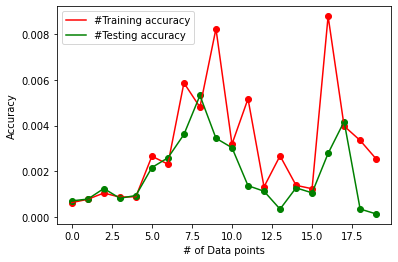

In [ ]:
plt.figure()
X_vals = [i for i in range(0,days_to_train)]

print(train_score_list)
print(test_score_list)
#Train_accuracy = [val for val in train_score_list]
#print(Train_accuracy)
#Test_accuracy = [val for val in test_score_list]
#print(Test_accuracy)
plt.scatter(X_vals,train_score_list,color='r')
plt.plot(X_vals,train_score_list,color='r',label='#Training accuracy')
plt.scatter(X_vals,test_score_list,color='g')
plt.plot(X_vals,test_score_list,color='g',label='#Testing accuracy')
plt.xlabel('# of Data points')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[0.0013419302613511472, 0.0013241481727807726, 0.001482522696579228, 0.0023495223755553014, 0.0015632684669007674, 0.001770291407396953, 0.004074085666107012, 0.004879800506137794, 0.006820888873506483, 0.009969652254607126, 0.006552081022588153, 0.00568585820336517, 0.002494577277071768, 0.002135724963936409, 0.0006265635268754191, 0.002438303031303787, 0.001982291205465641, 0.005133471856721945, 0.007810336414072566, 0.0006335387337071369]
[0.0013131744899487882, 0.0014561814412667486, 0.0023114107142888523, 0.0015232137952000625, 0.0017464458170719642, 0.004008975663129825, 0.0047897486889729645, 0.006680959198558004, 0.009832288896843256, 0.006373165714190068, 0.005609799047711658, 0.002540632505281826, 0.0020921292967196257, 0.0006453353932999395, 0.0023649041554903933, 0.0019609333014242543, 0.0051489852350082525, 0.007721477152240427, 0.0006532717039833489, 0.00025828391621850194]


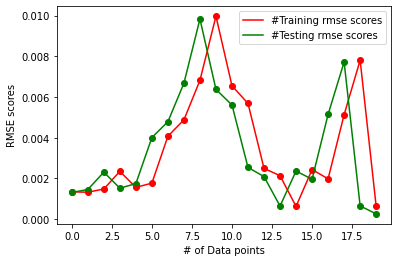

In [ ]:
plt.figure()
X_vals = [i for i in range(0,days_to_train)]

print(before_test_predict_rmse_score)
print(test_predict_rmse_score)
#Train_accuracy = [val for val in train_score_list]
#print(Train_accuracy)
#Test_accuracy = [val for val in test_score_list]
#print(Test_accuracy)
plt.scatter(X_vals,before_test_predict_rmse_score,color='r')
plt.plot(X_vals,before_test_predict_rmse_score,color='r',label='#Training rmse scores')
plt.scatter(X_vals,test_predict_rmse_score,color='g')
plt.plot(X_vals,test_predict_rmse_score,color='g',label='#Testing rmse scores')
plt.xlabel('# of Data points')
plt.ylabel('RMSE scores')
plt.legend()
plt.show()

[0.0014622033420795503, 0.0011719786415871826, 0.001440939593638355, 0.0019453312614148626, 0.0016130361507677759, 0.0016458569224346432, 0.0049141437243030665, 0.004275650427692429, 0.010834231385283435, 0.008877284096215536, 0.015202630777228204, 0.005893246558695736, 0.009552396921560945, 0.002443506085668643, 0.004946023264457294, 0.0025666106721643303, 0.0022898258713554597, 0.016216242460469425, 0.007354605137212545, 0.006190805068224926]
[0.0011724694780300747, 0.0014425878608841816, 0.0019471066419439206, 0.0016155866252617545, 0.001647091884504862, 0.004919268583267503, 0.004279804310116821, 0.010848242164847345, 0.008882901028720372, 0.015225443872732556, 0.005897380019315834, 0.009561193964639034, 0.002446026602264955, 0.004951903419121263, 0.002570006436026905, 0.0022911988497328, 0.016232799705071445, 0.007357338496761993, 0.006198662371235573, 0.004703742529160648]


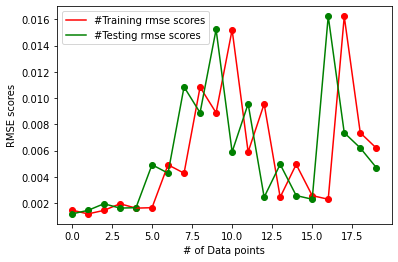

In [ ]:
plt.figure()
X_vals = [i for i in range(0,days_to_train)]

print(before_train_predict_rmse_score)
print(train_predict_rmse_score)
#Train_accuracy = [val for val in train_score_list]
#print(Train_accuracy)
#Test_accuracy = [val for val in test_score_list]
#print(Test_accuracy)
plt.scatter(X_vals,before_train_predict_rmse_score,color='r')
plt.plot(X_vals,before_train_predict_rmse_score,color='r',label='#Training rmse scores')
plt.scatter(X_vals,train_predict_rmse_score,color='g')
plt.plot(X_vals,train_predict_rmse_score,color='g',label='#Testing rmse scores')
plt.xlabel('# of Data points')
plt.ylabel('RMSE scores')
plt.legend()
plt.show()

In [ ]:
###Prediction and Result sections
X_test = x_test_new.copy()
y_test = y_test_new.copy()
if training_set_scaled.shape[1]==1:
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))#uncomment if only one column is used
predicted_stock_price = regressior.predict(X_test)
##Another scalar is created to get the be able to inverse transform only the Open price
scale = MinMaxScaler()
scale.min_,scale.scale_ = sc.min_[0],sc.scale_[0]##Taking the scalar values from the previous scalar
##Because the previous scalar had n dimensions but now the predicted is only 1 column

##The predicted price and the test data is inverse transformed
predicted_stock_price = scale.inverse_transform(predicted_stock_price)
y_test = scale.inverse_transform(y_test)#.reshape(-1,1))

Analysis on the testing set
[3.12 3.09 3.09 3.06 3.02 3.08 3.05 3.05 3.04 3.03 3.04 3.03 3.03 3.03
 3.04 3.03 3.02 3.01 3.02 3.03 3.02 3.  ]
The mean squared error value for the prediction:0.0002607142442086162


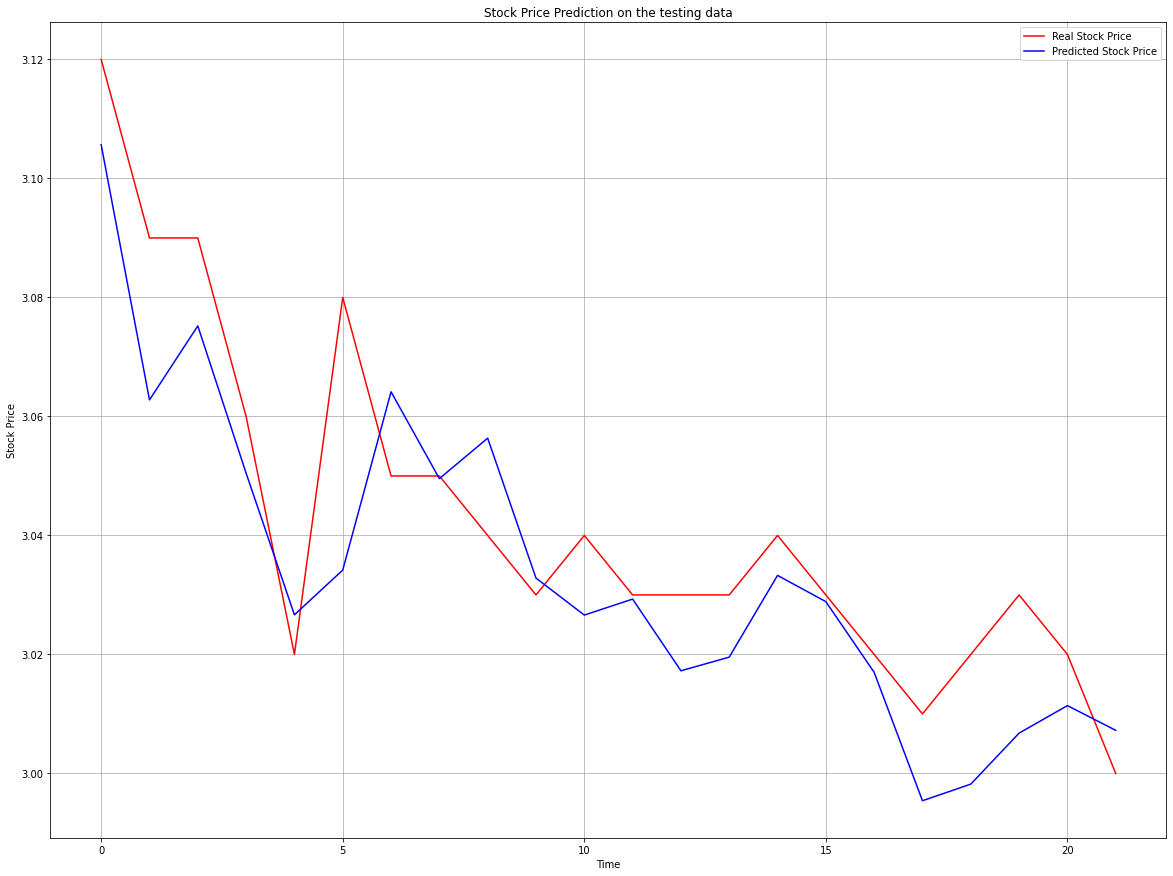

In [ ]:
###Graphical plots on the testing data to see its generalization power
###Even if multiple days are predicted the last day will be plotted
#print(y_test[:,-1])
#print(predicted_stock_price[:,-1])
print("Analysis on the testing set")
print(y_test[:,-1])
print("The mean squared error value for the prediction:" + str(mean_squared_error(y_test, predicted_stock_price)))
plt.figure(figsize=[20,15])
plt.grid(True)
plt.plot(y_test[:,-1], color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price[:,-1], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on the testing data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
#print(y_test)
#print(predicted_stock_price)

Analysis on the training set
The mean squared error value for the prediction:0.004696810450571354


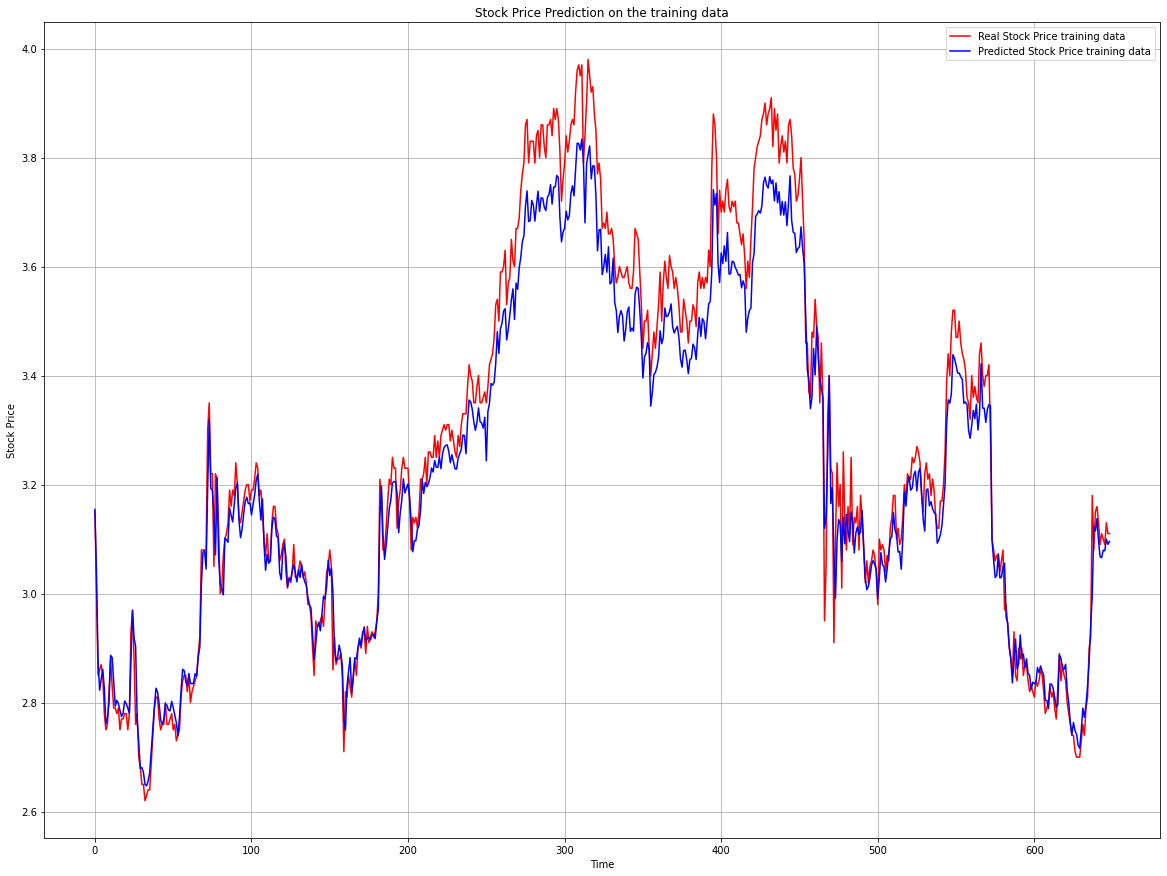

In [ ]:
###Plot a graph and calculate mse scores on the training data to see if the model is overfitted

print("Analysis on the training set")
X_train = x_train_new.copy()
y_train = y_train_new.copy()
predicted_stock_price_on_trainingset = regressior.predict(X_train)
##Another scalar is created to get the be able to inverse transform only the Open price
scale = MinMaxScaler()
scale.min_,scale.scale_ = sc.min_[0],sc.scale_[0]##Taking the scalar values from the previous scalar
##Because the previous scalar had n dimensions but now the predicted is only 1 column

##The predicted price and the test data is inverse transformed
predicted_stock_price_on_trainingset1 = scale.inverse_transform(predicted_stock_price_on_trainingset)
y_train1 = scale.inverse_transform(y_train)#.reshape(-1,1))

print("The mean squared error value for the prediction:" + str(mean_squared_error(y_train1, predicted_stock_price_on_trainingset1)))
#print(y_train1[:,-1])
#print(predicted_stock_price_on_trainingset1[:,-1])
plt.figure(figsize=[20,15])
plt.grid(True)
plt.plot(y_train1[:,-1], color = 'red', label = 'Real Stock Price training data')
plt.plot(predicted_stock_price_on_trainingset1[:,-1], color = 'blue', label = 'Predicted Stock Price training data')
plt.title('Stock Price Prediction on the training data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Plot graphs with the whole duration of 3 years

['Open', 'High', 'Low', 'Close', 'Two_day_sentiment_tweets', 'AverageSentimentNews', 'Date']
     Open   High    Low  ...  AverageSentimentNews       Date  Prediction
756  3.01  3.030  3.005  ...              0.062557 2020-12-23        3.01
757  3.02  3.035  3.010  ...              0.194700 2020-12-24        3.02
758  3.03  3.030  3.010  ...             -0.064000 2020-12-29        3.03
759  3.02  3.030  3.000  ...              0.200000 2020-12-30        3.02
760  3.00  3.010  2.980  ...             -0.009717 2020-12-31        3.00

[5 rows x 8 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


    Open   High    Low  ...  AverageSentimentNews       Date  Prediction
0   3.64  3.675  3.630  ...              0.000000 2018-01-02        3.64
1   3.67  3.685  3.645  ...              0.000000 2018-01-03        3.67
2   3.68  3.690  3.670  ...              0.000000 2018-01-04        3.68
3   3.70  3.730  3.690  ...              0.000000 2018-01-05        3.70
4   3.74  3.760  3.730  ...              0.096608 2018-01-08        3.74
5   3.77  3.785  3.750  ...              0.051350 2018-01-09        3.77
6   3.78  3.780  3.700  ...              0.000000 2018-01-10        3.78
7   3.70  3.735  3.680  ...             -0.200950 2018-01-11        3.70
8   3.73  3.750  3.700  ...              0.110332 2018-01-12        3.73
9   3.75  3.760  3.700  ...              0.025000 2018-01-15        3.75
10  3.70  3.700  3.640  ...              0.000000 2018-01-16        3.70
11  3.65  3.660  3.600  ...              0.131243 2018-01-17        3.65
12  3.63  3.660  3.610  ...              0.478643 2

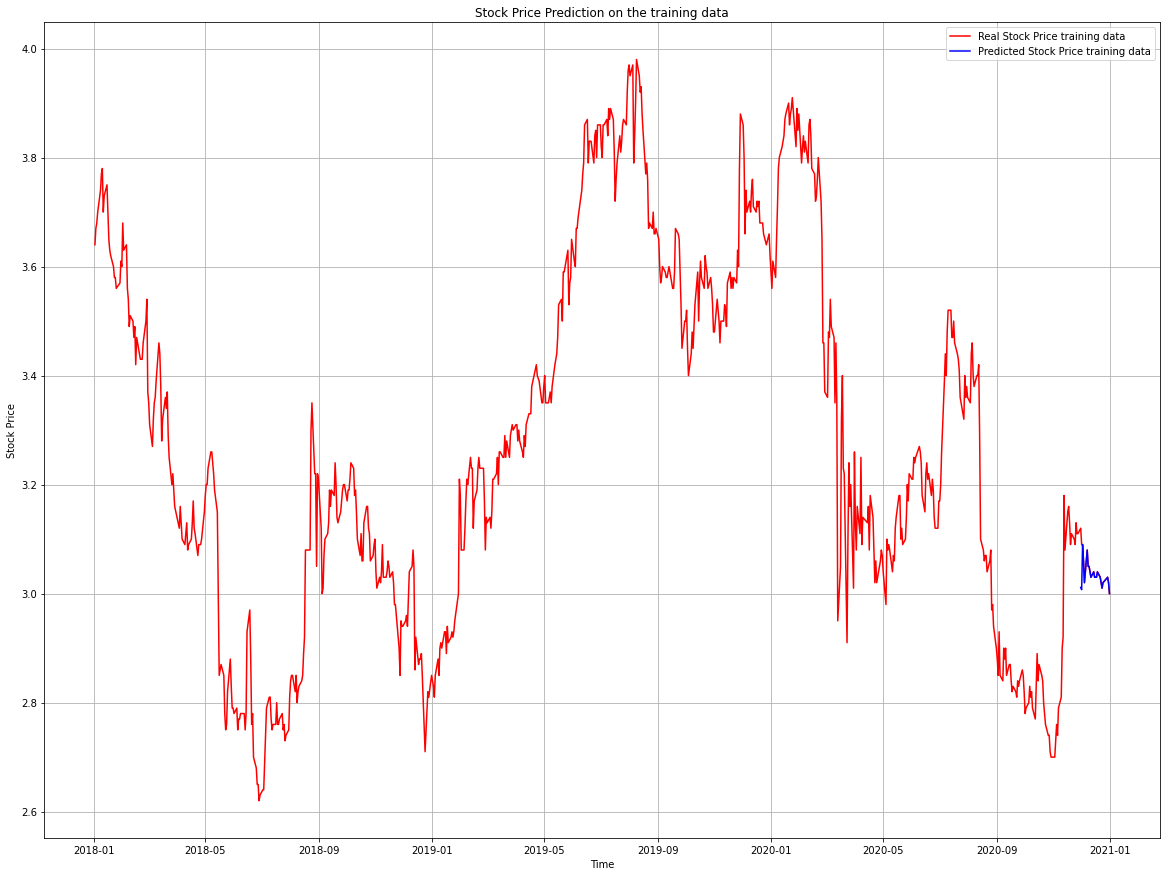

In [ ]:
###Plot graphs with the whole duration, and show the comparison of actual vs prediction
selected_columns_for_analysis = selected_columns
if 'Date' not in selected_columns_for_analysis:
  selected_columns_for_analysis.append('Date')
print(selected_columns_for_analysis)
analysis_data = dataset[selected_columns_for_analysis]
#print(analysis_data)
analysis_data['Prediction'] = analysis_data['Open']
print(analysis_data.tail())
##Append the prediction values to the dataframe
training_set_length = len(analysis_data[analysis_data['Date']<'2020-11-01'])
#print(predicted_stock_price)
for i in range(0,len(predicted_stock_price[:,-1])):
  #print(training_set_length+i)
  analysis_data.loc[training_set_length+i,'Prediction'] = predicted_stock_price[i,0]
  #print(str(predicted_stock_price[i,:])+" "+str(predicted_stock_price[i,0]))
  if i==(len(predicted_stock_price[:,-1])-1):
    #print("Last one")
    for j in range(1,future_days):
      analysis_data.loc[training_set_length+i+j,'Prediction'] = predicted_stock_price[i,j]
print(analysis_data.head(20))
print(analysis_data.tail(20))
plt.figure(figsize=[20,15])
plt.grid(True)
plt.plot(analysis_data['Date'], analysis_data['Open'],color = 'red', label = 'Real Stock Price training data')
analysis_plot_data = analysis_data.tail(len(predicted_stock_price[:,-1])+future_days-1)
plt.plot(analysis_plot_data['Date'],analysis_plot_data['Prediction'], color = 'blue', label = 'Predicted Stock Price training data')
plt.title('Stock Price Prediction on the training data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Computing the **moving average** on the prediction data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


     Open   High    Low  Close  ...       Date  Prediction    sma_50   sma_200
751  3.03  3.050  3.020   3.02  ... 2020-12-16        3.03  2.953975  3.094094
752  3.03  3.050  3.030   3.05  ... 2020-12-17        3.03  2.958175  3.091894
753  3.04  3.040  3.020   3.03  ... 2020-12-18        3.04  2.963175  3.090344
754  3.03  3.035  3.010   3.03  ... 2020-12-21        3.03  2.968375  3.088194
755  3.02  3.030  3.000   3.00  ... 2020-12-22        3.02  2.972175  3.086544
756  3.01  3.030  3.005   3.01  ... 2020-12-23        3.01  2.974575  3.086844
757  3.02  3.035  3.010   3.01  ... 2020-12-24        3.02  2.978175  3.086694
758  3.03  3.030  3.010   3.02  ... 2020-12-29        3.03  2.981375  3.085244
759  3.02  3.030  3.000   3.00  ... 2020-12-30        3.02  2.984775  3.083344
760  3.00  3.010  2.980   2.98  ... 2020-12-31        3.00  2.987975  3.082194

[10 rows x 10 columns]


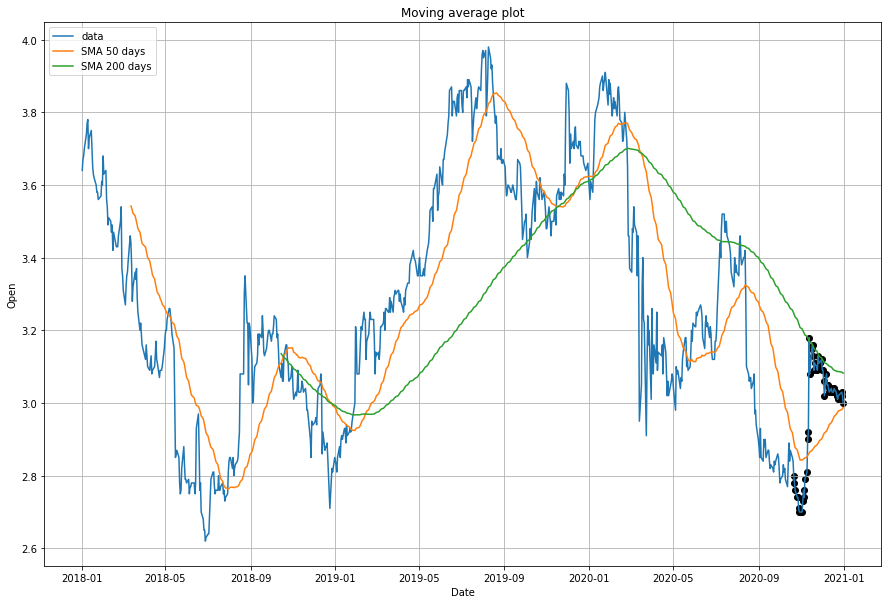

In [ ]:
col = analysis_data.columns.get_loc("Prediction")
analysis_data['sma_50'] = analysis_data.iloc[:,col].rolling(window=50).mean()##Just to check if the above command is implemented properly
analysis_data['sma_200'] = analysis_data.iloc[:,col].rolling(window=200).mean()
print(analysis_data.tail(10))
last_50_days = analysis_data.tail(50)
highlight_dict_golden = {'index':[],'Open':[]}
highlight_dict_death = {'index':[],'Open':[]}
period = {'index':[],'Open':[]}


#print(last_50_days)
date_col = analysis_data.columns.get_loc("Date")
###Highlight the golden and death cross points
for index, each_day in last_50_days.iterrows():
  period['index'].append(each_day['Date'])
  period['Open'].append(each_day['Open'])
  if each_day['sma_50']>each_day['sma_200']:
    highlight_dict_golden['index'].append(each_day['Date'])
    highlight_dict_golden['Open'].append(each_day['Open'])
  if each_day['sma_50']<each_day['sma_200']:
    highlight_dict_death['index'].append(each_day['Date'])
    highlight_dict_death['Open'].append(each_day['Open'])
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(analysis_data['Date'],analysis_data['Open'],label='data')
plt.plot(analysis_data['Date'],analysis_data['sma_50'],label='SMA 50 days')
plt.plot(analysis_data['Date'],analysis_data['sma_200'],label='SMA 200 days')
plt.title('Moving average plot')
plt.xlabel('Date')
plt.ylabel('Open')
plt.legend(loc=2)
plt.scatter(highlight_dict_golden['index'],highlight_dict_golden['Open'],color="yellow")
plt.scatter(highlight_dict_death['index'],highlight_dict_death['Open'],color="black")
plt.show()   